In [2]:
!nvidia-smi

Sun Nov  2 09:44:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!unzip -q /content/labeled_data.zip -d /content/custom_data

In [5]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-11-02 09:47:25--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-11-02 09:47:25 (54.4 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 14
Number of annotation files: 14
Images moving to train: 12
Images moving to validation: 2


In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.6 MB/s eta 0:00:00


In [8]:
with open('/content/custom_data/classes.txt', 'r') as f:
  label = f.readlines()
  print(label)

['caption-image\n', 'image\n']


In [9]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- caption-image
- image


In [10]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj

In [14]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True save_txt=True save_conf=True

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/2 /content/data/validation/images/c474b043-67.png: 640x480 2 images, 50.9ms
image 2/2 /content/data/validation/images/e1253a39-26.png: 640x448 3 caption-images, 3 images, 51.9ms
Speed: 2.6ms preprocess, 51.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/runs/detect/predict2
2 labels saved to /content/runs/detect/predict2/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


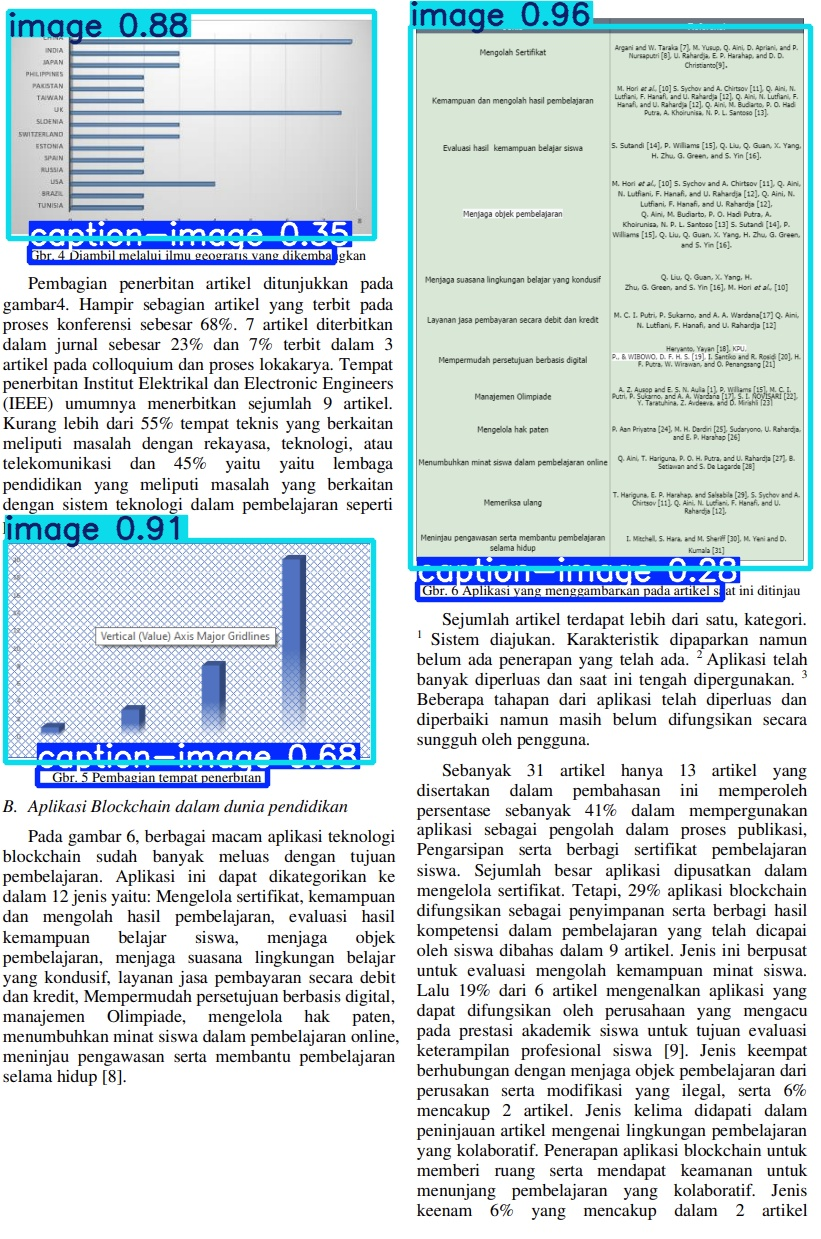

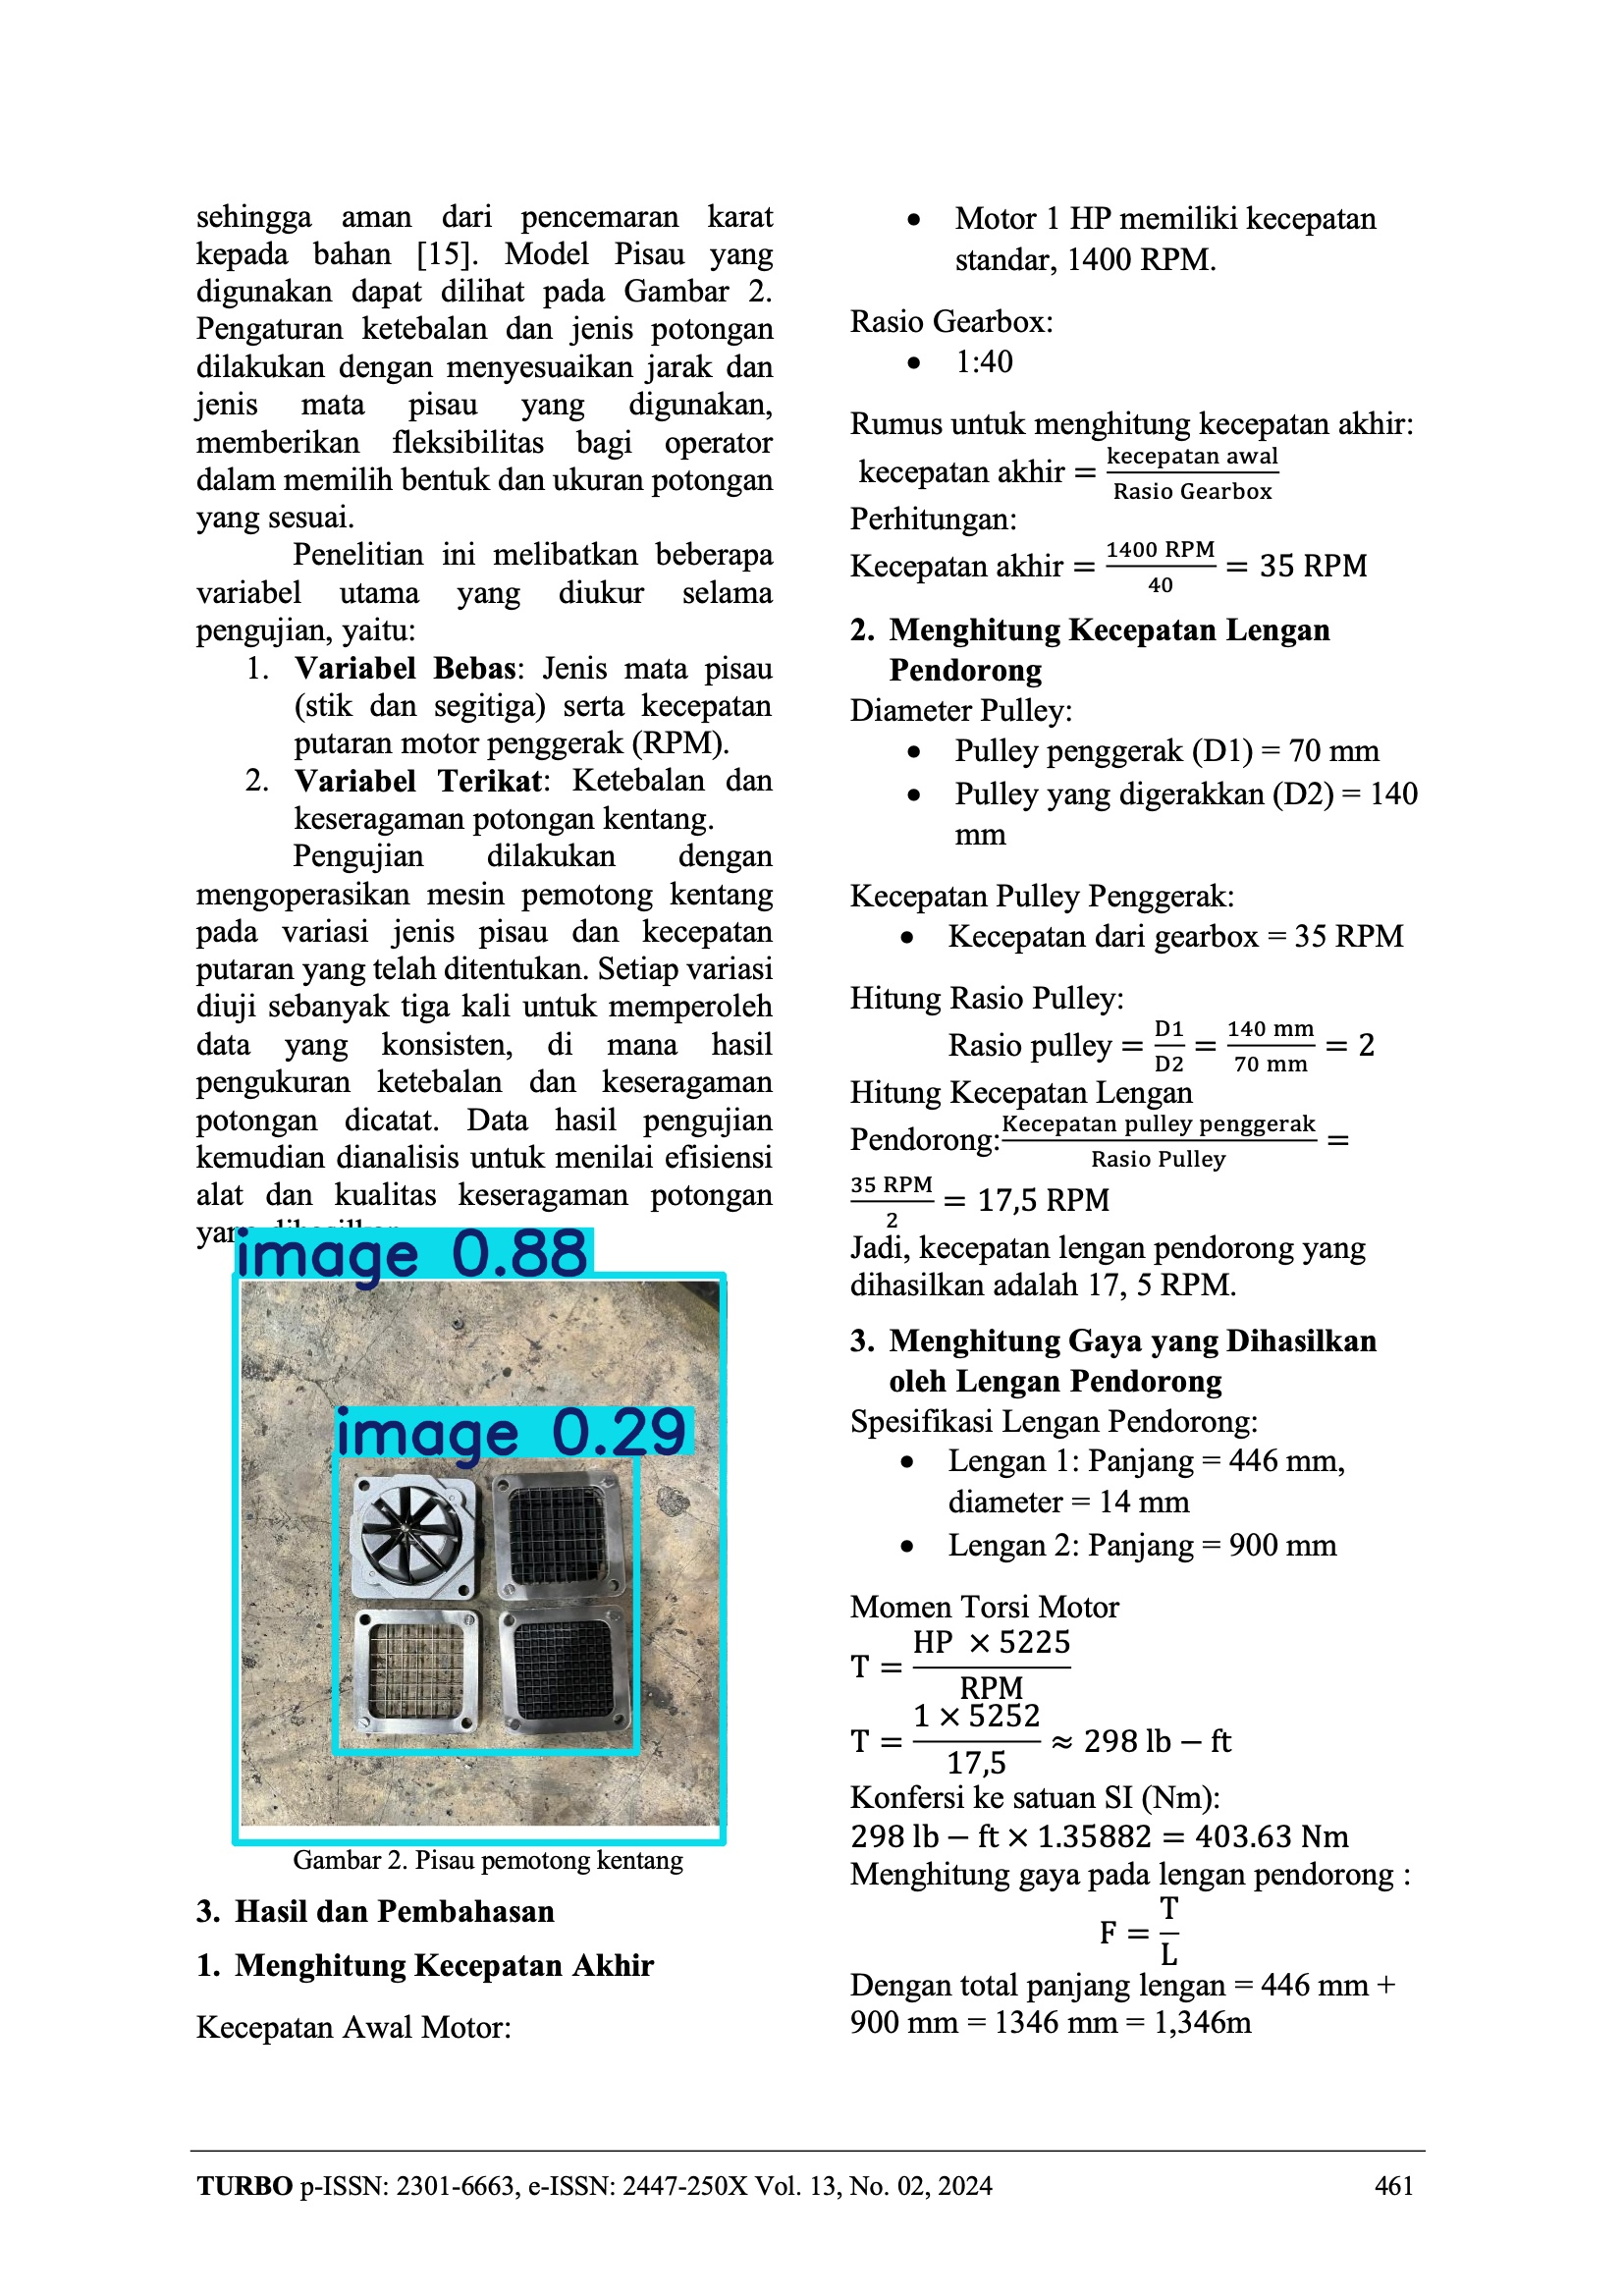

In [15]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


In [24]:
import os
import glob
from PIL import Image

# Paths
label_dir = '/content/runs/detect/predict2/labels'
image_dir = '/content/runs/detect/predict2'

for label_path in glob.glob(os.path.join(label_dir, '*.txt')):
    image_name = os.path.splitext(os.path.basename(label_path))[0] + '.jpg'
    image_path = os.path.join(image_dir, image_name)

    img = Image.open(image_path)
    img_width, img_height = img.size

    with open(label_path, 'r') as f:
        lines = f.readlines()

    print(f"Image: {image_name}")
    for line in lines:
        print(line, end='')
        cls, x_center, y_center, w, h, confidence = map(float, line.strip().split())

        # Convert normalized → pixel coordinates
        x_min = int((x_center - w / 2) * img_width)
        y_min = int((y_center - h / 2) * img_height)
        x_max = int((x_center + w / 2) * img_width)
        y_max = int((y_center + h / 2) * img_height)

        print(f"Class {int(cls)}: (x_min={x_min}, y_min={y_min}), (x_max={x_max}, y_max={y_max})")
        print(f"Image width: {img_width}, image height: {img_height}")
        print()
    print("=====================================================================")


Image: c474b043-67.jpg
1 0.29494 0.678982 0.300611 0.247562 0.87596
Class 1: (x_min=239, y_min=1298), (x_max=736, y_max=1876)
Image width: 1654, image height: 2338

1 0.299381 0.69823 0.18533 0.129699 0.292812
Class 1: (x_min=341, y_min=1480), (x_max=648, y_max=1784)
Image width: 1654, image height: 2338

Image: e1253a39-26.jpg
1 0.743637 0.240071 0.486598 0.437902 0.96141
Class 1: (x_min=410, y_min=26), (x_max=810, y_max=568)
Image width: 821, image height: 1239

1 0.230683 0.525643 0.447794 0.178926 0.905123
Class 1: (x_min=5, y_min=540), (x_max=373, y_max=762)
Image width: 821, image height: 1239

1 0.233428 0.10115 0.446461 0.18296 0.878325
Class 1: (x_min=8, y_min=11), (x_max=374, y_max=238)
Image width: 821, image height: 1239

0 0.185362 0.62706 0.280033 0.0138863 0.684757
Class 0: (x_min=37, y_min=768), (x_max=267, y_max=785)
Image width: 821, image height: 1239

0 0.221475 0.205214 0.372152 0.0128074 0.351085
Class 0: (x_min=29, y_min=246), (x_max=334, y_max=262)
Image width: 

In [25]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/yolo_model1
!cp /content/runs/detect/train/weights/best.pt /content/yolo_model1/yolo_model1.pt
!cp -r /content/runs/detect/train /content/yolo_model1
!cp -r /content/runs/detect/predict2/ /content/yolo_model1

# Zip into "yolo_model1.zip"
%cd yolo_model1
!zip /content/yolo_model1.zip yolo_model1.pt
!zip -r /content/yolo_model1.zip train
!zip -r /content/yolo_model1.zip predict2
%cd /content

/content/yolo_model1
  adding: yolo_model1.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/labels.jpg (deflated 47%)
  adding: train/BoxP_curve.png (deflated 14%)
  adding: train/results.png (deflated 6%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/confusion_matrix_normalized.png (deflated 34%)
  adding: train/args.yaml (deflated 53%)
  adding: train/train_batch1.jpg (deflated 7%)
  adding: train/BoxF1_curve.png (deflated 10%)
  adding: train/results.csv (deflated 67%)
  adding: train/val_batch0_pred.jpg (deflated 13%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/BoxR_curve.png (deflated 14%)
  adding: train/train_batch2.jpg (deflated 7%)
  adding: train/train_batch0.jpg (deflated 8%)
  adding: train/train_batch51.jpg (deflated 16%)
  adding: train/train_batch52.jpg (deflated 11%)
  adding: train/BoxPR_curve.png (deflated 28%)
  adding: train/val_bat